#Trabalho Prático 2

**Nome: Daniel Pimentel Kansaon**

**Matrícula: 2018718007**


`O objetivo deste trabalho é de praticar o uso de Convolutional Neural Networks(CNN) e de Transfer Learning.  Neste trabalho foi construído uma Rede neural Convolucional (CNNs) para classificação de imagens. Ao todo, 2 CNNs utilizaram o conceito de Transfer Learning. De maneira geral, a melhor rede apresentou uma acurácia acima de 85%.`

# Bibliotecas

In [0]:
import matplotlib as mpl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models

from keras import utils

# Tira os warning do TF
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def printmd(s):
    display(Markdown(s))

# Constantes

In [0]:
ULTIMOS_DIGITOS_MATRICULA = [0, 7] #Os dois últimos digitos da matrícula. Classe 7 = cavalo e Classe 0 = Avião

N_CLASSES = 10 # Existe 10 tipo de imagens, ou seja, 10 classes diferentes

NUM_BATCH_SIZE = 128 # A quantidade de exemplos que serão propagados pela rede até a correção dos erros pelo backpropagation

NUM_EPOCHS = 20 # Quantidade de epocas que a rede neural será executada

#Métodos Comuns

In [0]:
def plot_acc(history):
    # Gera graficos do resultado do treino
    mpl.rc("font", **{"size": 14})
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))

    # Loss
    axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
    label="Train Loss", color="royalblue", lw=3)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_xticks(range(1, len(history.history["acc"])+1))
    axes[0].legend()

    # Accuracy
    axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
    label="Train ACC", color="royalblue", lw=3)
    axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
    label="Teste ACC", color="forestgreen", lw=3)
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_xticks(range(1, len(history.history["acc"])+1))
    axes[1].legend()
    plt.show()

In [0]:
def plot_confusion_matrix(model, x_train, y_train):    
    # Predições
    y_proba = model.predict(x_train)
    y_pred = np.argmax(y_proba, axis=1)

    # Labels (desfaz o one-hot encode)
    y_true = np.argmax(y_train, axis=1)

    cm = metrics.confusion_matrix(y_true, y_pred)
    classes = list(range(1, 11))
    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=classes, yticklabels=classes,
    title="Matriz de Confusão",
    ylabel="Real",
    xlabel="Predito")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    plt.show()

# Obtendo Dados

In [0]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Exemplo das imagens

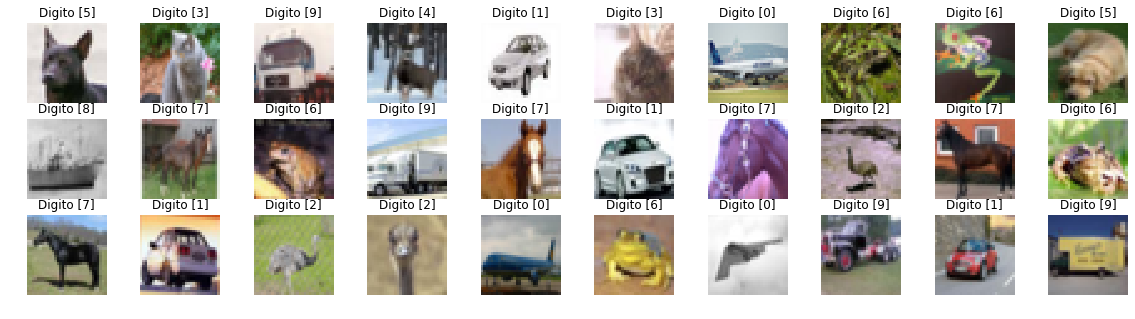

In [7]:
n_rows = 3
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_train.shape[0])
        axes[i][j].imshow(x_train[img_i], cmap="gray")
        axes[i][j].set_title("Digito {}".format(y_train[img_i]))
        axes[i][j].axis("off")
plt.show()

# Obtendo o formato da imagem e a quantidade de imagens

In [0]:
img_shape = x_train.shape[1:]

#Converte o vetor obtido no dataset para ONE-HOT ENCODING
y_train = utils.to_categorical(y_train, N_CLASSES)
y_test = utils.to_categorical(y_test, N_CLASSES)

#Normalização

In [0]:
x_train = x_train/255
x_test = x_test/255

# Separando dados em parte A e B

In [0]:
#Verifica se a imagem(vector) é da classe contida no número de matrícula
def verify_class(vector):
    for i in ULTIMOS_DIGITOS_MATRICULA:
        if (vector[i] == 1.0):
            return 1
    return 0

#Obtêm os indices das imagens que são da classe [0 ou 7], que são os últimos digitos da matricula.
index_train_digit = list(filter(lambda x: verify_class(y_train[x]) == 1, range(y_train.shape[0])))
index_test_digit = list(filter(lambda x: verify_class(y_test[x]) == 1, range(y_test.shape[0])))
#index_test_digit = list(filter(lambda x: y_test[x] in (ULTIMOS_DIGITOS_MATRICULA), range(len(y_test))))

#Cria a parte B dos dados
b_x_train = x_train[index_train_digit]
b_y_train = y_train[index_train_digit]
b_x_test = x_test[index_test_digit]
b_y_test = y_test[index_test_digit]

#Cria os dados da parte A, removendo os indices presentes em B
a_x_train = np.delete(x_train, index_train_digit, 0)
a_y_train = np.delete(y_train, index_train_digit, 0)
a_x_test = np.delete(x_test, index_test_digit, 0)
a_y_test = np.delete(y_test, index_test_digit, 0)

# Definindo CNN

O modelo CNN tem basicamente 2 camadas de convolução seguidas de 1 pooling. Essa repetição ocorre 2 vezes até chegar nas duas camadas densa.

In [0]:
def load_cnn_model(train_weight=True, train_penult_dense=True):
    model_input = layers.Input(shape=img_shape, name="Input")        
    
    # 2 camadas de convolucao e 1 de pooling
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1", trainable=train_weight)(model_input)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2", trainable=train_weight)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool1", trainable=train_weight)(x)
       
    # 2 camadas de convolucao e 1 de pooling, semelhante a anterior
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv3", trainable=train_weight)(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv4", trainable=train_weight)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool2", trainable=train_weight)(x)
    
    # Probabilidade de remover cada neuronio, ajudando a controlar o overffitig
    x = layers.Dropout(0.25, name="Dropout1")(x)
    
    # Camada que "achata" para depois usar em camadas fully connected
    x = layers.Flatten(name="Flatten", trainable=train_weight)(x)      
         
    # Camada densa totalmente conectada
    x = layers.Dense(128, activation="relu", name="Dense1", trainable=train_penult_dense)(x)    
    
    # Probabilidade de remover cada neuronio, ajudando a controlar o overffitig
    x = layers.Dropout(0.25, name="Dropout2")(x)
    
    # Ultima camada densa com uma função de ativação softmax, que tem como saida a probabilidade da
    model_output = layers.Dense(N_CLASSES, activation='softmax', name="OutpuLayer")(x)
        
    model = models.Model(model_input, model_output)
    model.summary()
    
    return model

In [0]:
def execute_model(model, x_train, y_train, x_test, y_test):
    
    # O Adam algoritmo é uma otimização do tradicional Stochastic Gradient Descent. Geralmente alcanca um bom resultado mais rapidamente.
    optimizer = optimizers.Adam(lr=0.01)

    # Compila o modelo e escolhe a funcao de perda e a principal métrica utilizada, no caso, acuracia.
    model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    # Treinando a rede
    result = model.fit(x_train, y_train, batch_size=NUM_BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_test, y_test))
    
    return result

# Treinando a parte (A) dos dados

In [125]:
cnn_model_a = load_cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
__________

In [126]:
history_a = execute_model(cnn_model_a, a_x_train, a_y_train, a_x_test, a_y_test)

Train on 40000 samples, validate on 8000 samples
Epoch 1/20
40000/40000 [==============================] - 9s 218us/step - loss: 1.8621 - acc: 0.3118 - val_loss: 1.5799 - val_acc: 0.3792
Epoch 2/20
40000/40000 [==============================] - 6s 146us/step - loss: 1.5407 - acc: 0.4083 - val_loss: 1.4025 - val_acc: 0.4627
Epoch 3/20
40000/40000 [==============================] - 6s 146us/step - loss: 1.4248 - acc: 0.4529 - val_loss: 1.3134 - val_acc: 0.4914
Epoch 4/20
40000/40000 [==============================] - 6s 146us/step - loss: 1.3782 - acc: 0.4693 - val_loss: 1.2729 - val_acc: 0.5114
Epoch 5/20
40000/40000 [==============================] - 6s 146us/step - loss: 1.3359 - acc: 0.4882 - val_loss: 1.2811 - val_acc: 0.4971
Epoch 6/20
40000/40000 [==============================] - 6s 145us/step - loss: 1.3140 - acc: 0.4981 - val_loss: 1.2707 - val_acc: 0.5096
Epoch 7/20
40000/40000 [==============================] - 6s 145us/step - loss: 1.2850 - acc: 0.5153 - val_loss: 1.2201 - v

##Resultado parte A

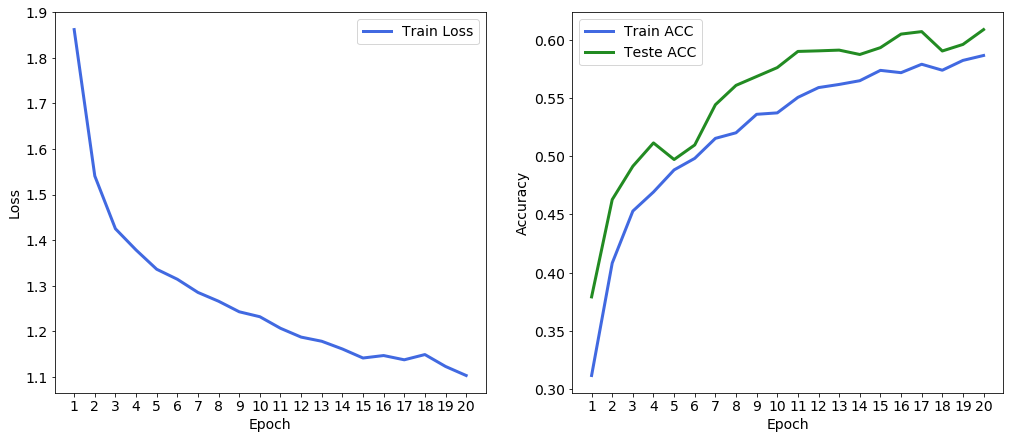

In [127]:
plot_acc(history_a)

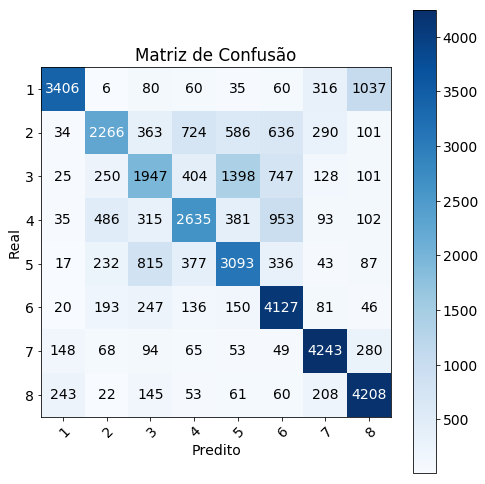

In [128]:
plot_confusion_matrix(cnn_model_a, a_x_train, a_y_train)

# B1 - Treinando a segunda parte (B) sem transfer learning

In [129]:
cnn_model_b = load_cnn_model()
history_b_without_tuning = execute_model(cnn_model_b, b_x_train, b_y_train, b_x_test, b_y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
__________

##Resultado B1

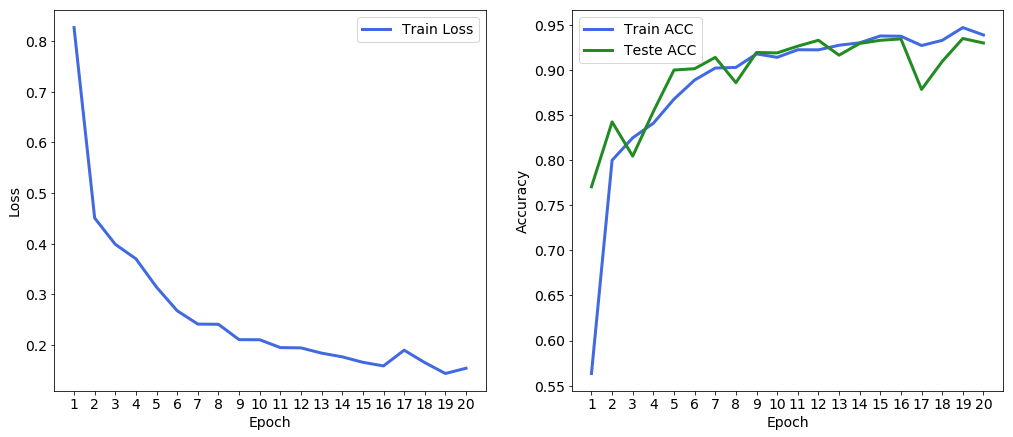

In [130]:
plot_acc(history_b_without_tuning)

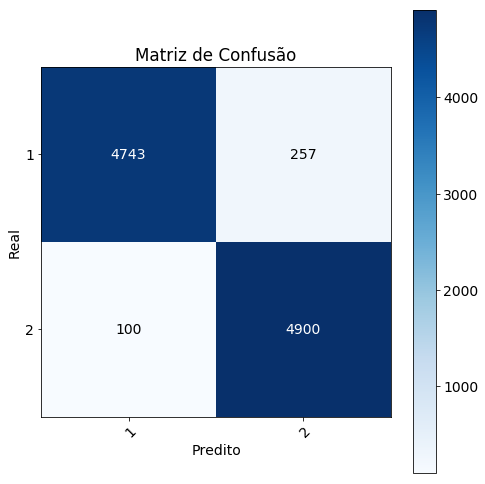

In [131]:
plot_confusion_matrix(cnn_model_b, b_x_train, b_y_train)

#B2 - Fine-tuning em  uma  camada

In [132]:
cnn_model_tuning1 = load_cnn_model(False, True)
cnn_model_tuning1.set_weights(cnn_model_a.get_weights())
history_b_tuning1 = execute_model(cnn_model_tuning1, b_x_train, b_y_train, b_x_test, b_y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
__________

##Resultado B2

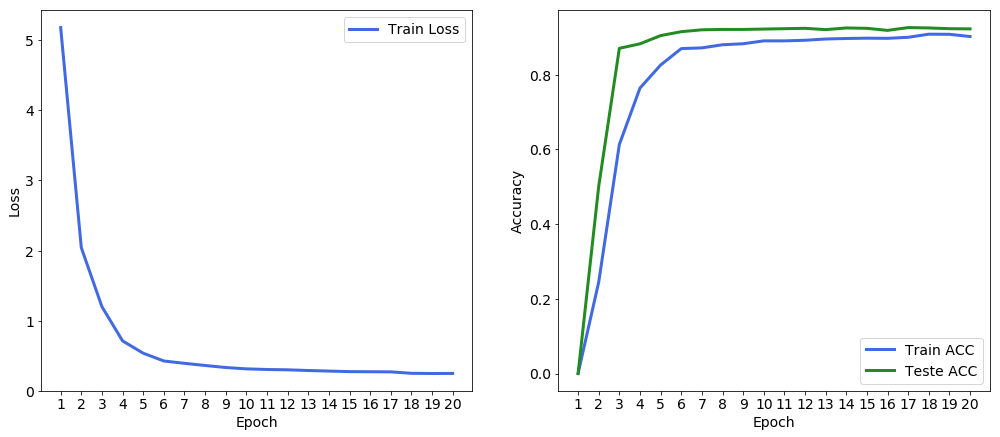

In [133]:
plot_acc(history_b_tuning1)

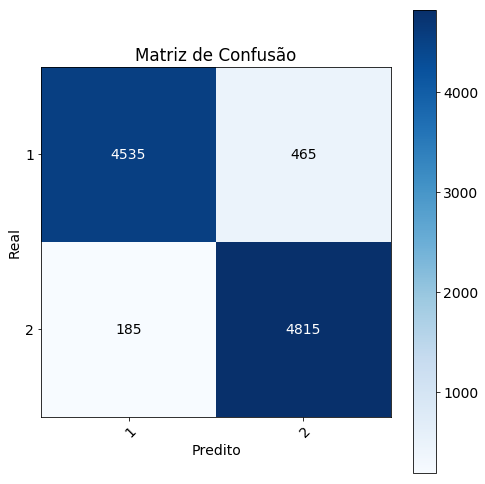

In [134]:
plot_confusion_matrix(cnn_model_tuning1, b_x_train, b_y_train)

#B3 - Fine-tuningem  duas  camadas

In [135]:
cnn_model_tuning2 = load_cnn_model(False, False)
cnn_model_tuning2.set_weights(cnn_model_a.get_weights())
history_b_tuning2 = execute_model(cnn_model_tuning2, b_x_train, b_y_train, b_x_test, b_y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
__________

##Resultado B3

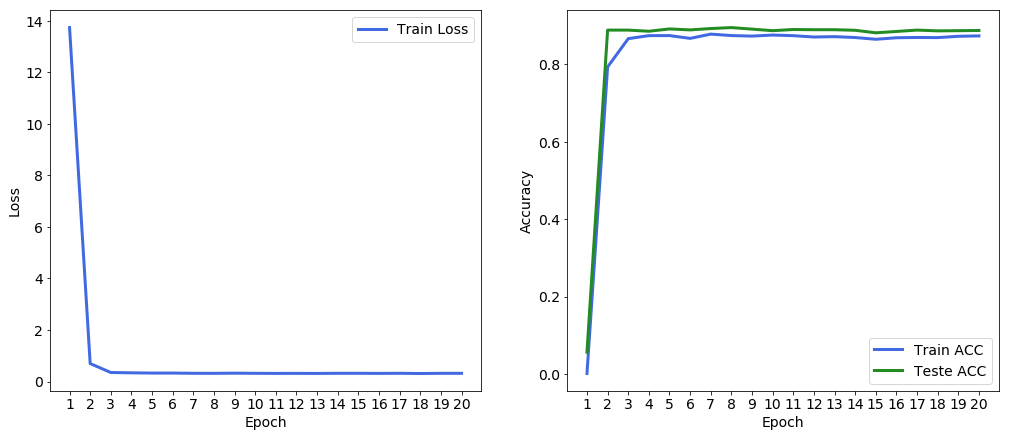

In [136]:
plot_acc(history_b_tuning2)

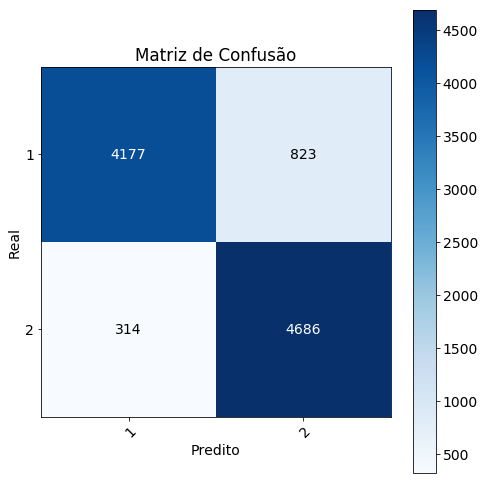

In [137]:
plot_confusion_matrix(cnn_model_tuning2, b_x_train, b_y_train)